In [29]:
# import all necessary libraries
import os
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from tqdm import tqdm
from pathlib import Path
from utils.OpenMeteoWeather import OpenMeteoWeather
import math

from datetime import datetime
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [30]:
START_DATE = '2022-12-03'
END_DATE = '2025-03-01'
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    
    "minimum_longitude":9.10,
    "maximum_longitude":30.20,
    "minimum_latitude":53.10,
    "maximum_latitude":65.00,

    # "minimum_longitude":9.85083510071235,
    # "maximum_longitude":10.926709174713364,
    # "minimum_latitude":54.25206332481298,
    # "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365,

    'min_lon_obs': 10.204,
    'min_lat_obs': 54.382999,
    'max_lon_obs': 10.204,
    'max_lat_obs': 54.382999,
    
    }

In [31]:
from utils.Copernicus import AdvancedCopernicus
copernicus = AdvancedCopernicus()


variables = ['sla']
# Calculate Radius
radius = 0.001 # 


data = copernicus.get_subset(
    dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
    dataset_version="202411",
    variables=variables,
    minimum_longitude=BBOX['min_lon_obs'],
    maximum_longitude=BBOX['max_lon_obs'],
    minimum_latitude=BBOX['min_lat_obs'],  
    maximum_latitude=BBOX['max_lat_obs'],


    start_datetime=START_DATE,
    end_datetime=END_DATE,
    minimum_depth=0.5016462206840515,
    maximum_depth=0.5016462206840515,
    coordinates_selection_method="strict-inside",
    disable_progress_bar=False,
    output_filename='file.nc',
    delete_file=True)

INFO - 2025-03-14T13:56:24Z - Selected dataset version: "202411"
INFO - 2025-03-14T13:56:24Z - Selected dataset part: "default"
INFO - 2025-03-14T13:56:28Z - Starting download. Please wait...
100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
INFO - 2025-03-14T13:56:30Z - Successfully downloaded to file.nc


In [32]:
df_model = data.to_dataframe().reset_index()
df_model.groupby('time').mean()
df_model['time'] = pd.to_datetime(df_model['time'])

df_model.info()
df_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19657 entries, 0 to 19656
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       19657 non-null  datetime64[ns]
 1   latitude   19657 non-null  float32       
 2   longitude  19657 non-null  float32       
 3   sla        19657 non-null  float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 384.1 KB


,time,latitude,longitude,sla
0,2022-12-03 00:00:00,54.374943,10.208244,0.011799
1,2022-12-03 01:00:00,54.374943,10.208244,-0.009020
2,2022-12-03 02:00:00,54.374943,10.208244,-0.000958
3,2022-12-03 03:00:00,54.374943,10.208244,-0.051679
4,2022-12-03 04:00:00,54.374943,10.208244,-0.073137


In [33]:

f = 'data/NO_TS_TG_KielHoltenauTG.nc'
ds = xr.open_dataset(f)
df_observation = ds.to_dataframe().reset_index()

df_observation = df_observation[df_observation['SLEV_QC'] == 1]


# Group the Data hurly and take the mean
df_observation.set_index('TIME', inplace=True)


df_observation = df_observation.resample('h').mean(numeric_only=True)
df_observation.reset_index(inplace=True)
df_observation.info()
df_observation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97410 entries, 0 to 97409
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TIME       97410 non-null  datetime64[ns]
 1   DEPTH      95909 non-null  float64       
 2   TIME_QC    95909 non-null  float64       
 3   DEPH       95909 non-null  float32       
 4   LATITUDE   95909 non-null  float32       
 5   LONGITUDE  95909 non-null  float32       
 6   SLEV       95909 non-null  float32       
 7   SLEV_QC    95909 non-null  float32       
dtypes: datetime64[ns](1), float32(5), float64(2)
memory usage: 4.1 MB


,TIME,DEPTH,TIME_QC,DEPH,LATITUDE,LONGITUDE,SLEV,SLEV_QC
0,2014-01-19 06:00:00,0.0,1.0,0.0,54.382999,10.204,0.526667,1.0
1,2014-01-19 07:00:00,0.0,1.0,0.0,54.382999,10.204,0.550000,1.0
2,2014-01-19 08:00:00,0.0,1.0,0.0,54.382999,10.204,0.576667,1.0
3,2014-01-19 09:00:00,0.0,1.0,0.0,54.382999,10.204,0.616667,1.0
4,2014-01-19 10:00:00,0.0,1.0,0.0,54.382999,10.204,0.647667,1.0


In [34]:
df_merged = pd.merge(df_model, df_observation, left_on='time', right_on='TIME', how='inner')
df_merged.drop(columns=['TIME'], inplace=True)
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19656 entries, 0 to 19655
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       19656 non-null  datetime64[ns]
 1   latitude   19656 non-null  float32       
 2   longitude  19656 non-null  float32       
 3   sla        19656 non-null  float32       
 4   DEPTH      19652 non-null  float64       
 5   TIME_QC    19652 non-null  float64       
 6   DEPH       19652 non-null  float32       
 7   LATITUDE   19652 non-null  float32       
 8   LONGITUDE  19652 non-null  float32       
 9   SLEV       19652 non-null  float32       
 10  SLEV_QC    19652 non-null  float32       
dtypes: datetime64[ns](1), float32(8), float64(2)
memory usage: 1.0 MB


,time,latitude,longitude,sla,DEPTH,TIME_QC,DEPH,LATITUDE,LONGITUDE,SLEV,SLEV_QC
0,2022-12-03 00:00:00,54.374943,10.208244,0.011799,0.0,1.0,0.0,54.382999,10.204,0.396333,1.0
1,2022-12-03 01:00:00,54.374943,10.208244,-0.009020,0.0,1.0,0.0,54.382999,10.204,0.379667,1.0
2,2022-12-03 02:00:00,54.374943,10.208244,-0.000958,0.0,1.0,0.0,54.382999,10.204,0.308000,1.0
3,2022-12-03 03:00:00,54.374943,10.208244,-0.051679,0.0,1.0,0.0,54.382999,10.204,0.263000,1.0
4,2022-12-03 04:00:00,54.374943,10.208244,-0.073137,0.0,1.0,0.0,54.382999,10.204,0.193000,1.0


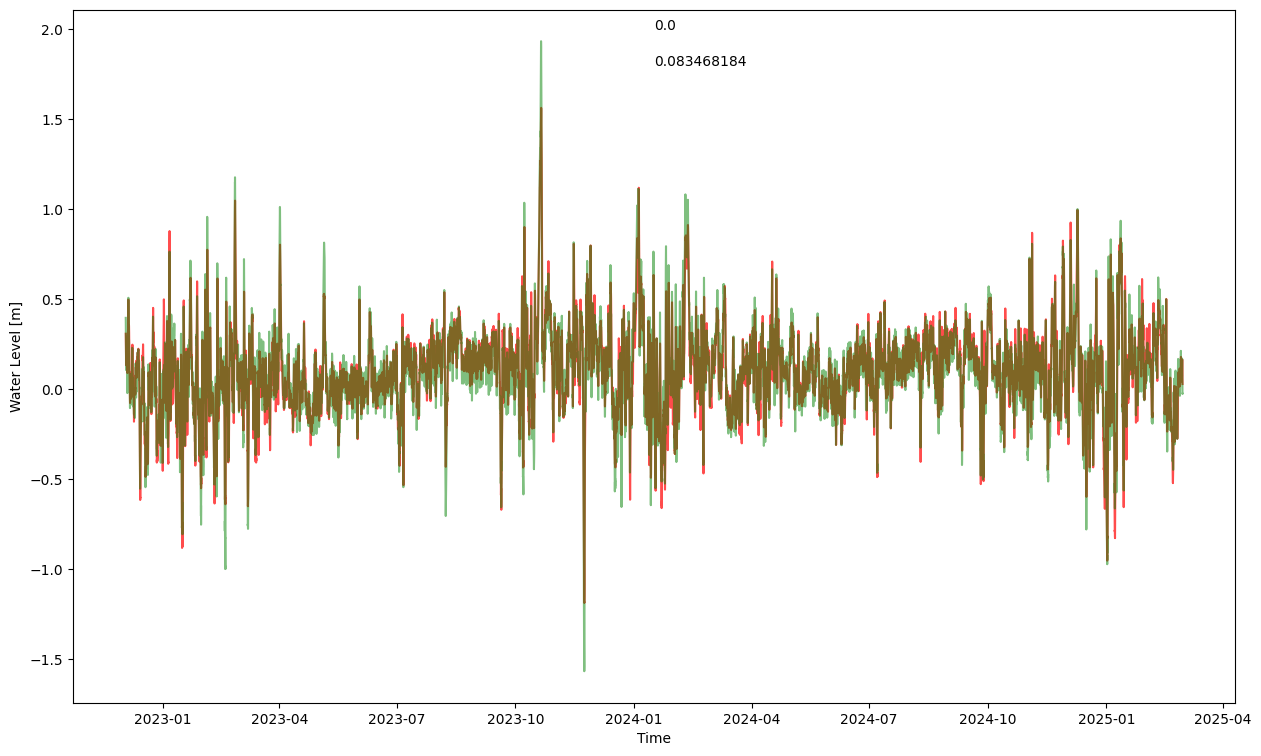

In [69]:
df_merged['SLEV_diff'] = df_merged['SLEV'] - df_merged['sla']

deviation_mean = df_merged['SLEV_diff'].mean()

df_merged['sla'] = df_merged['sla'] + deviation_mean
diff = np.mean((df_merged['SLEV'] - df_merged['sla']))
std = np.std(df_merged['SLEV'] - df_merged['sla'])
fig = plt.figure(figsize=(15, 9))

plt.plot(df_merged['time'], df_merged['sla'], color='red', alpha=0.7)
plt.plot(df_merged['time'], df_merged['SLEV'], color='green', alpha=0.5)
plt.text(x=df_merged['time'].mean(), y=2, s=diff)
plt.text(x=df_merged['time'].mean(), y=1.8, s=std)

plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='Water Level [m]')

plt.show()